In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving mlb batting - 2021.csv to mlb batting - 2021.csv
Saving mlb batting - 2022.csv to mlb batting - 2022.csv
Saving mlb pitching - 2022.csv to mlb pitching - 2022.csv
Saving mlb pitching - 2021.csv to mlb pitching - 2021.csv


In [ ]:
import pandas as pd
import requests
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup

batting = pd.read_csv("mlb batting - 2021.csv")
pitching = pd.read_csv("mlb pitching - 2021.csv")
batting = batting[["Team", "ISO", "BABIP", "AVG", "wRC+", "WAR"]]
pitching = pitching[["Team", "W", "L", "ERA", "WAR", "K/9", "xFIP"]]
pitching["PCT"] = pitching["W"] / ( pitching ["L"] + pitching ["W"])
pitching = pitching.drop(["W", "L"], axis = 1)
print(batting.columns)
print(pitching.columns)
print(pitching["PCT"])


Index(['Team', 'ISO', 'BABIP', 'AVG', 'wRC+', 'WAR'], dtype='object')
Index(['Team', 'ERA', 'WAR', 'K/9', 'xFIP', 'PCT'], dtype='object')
0     0.574074
1     0.654321
2     0.586420
3     0.567901
4     0.660494
5     0.567901
6     0.617284
7     0.506173
8     0.586420
9     0.475309
10    0.512346
11    0.546584
12    0.475309
13    0.530864
14    0.413580
15    0.561728
16    0.555556
17    0.459627
18    0.487654
19    0.456790
20    0.555556
21    0.493827
22    0.475309
23    0.450617
24    0.320988
25    0.401235
26    0.376543
27    0.438272
28    0.370370
29    0.320988
Name: PCT, dtype: float64


In [ ]:
all_data = pd.merge(left=batting, right=pitching, left_on='Team', right_on='Team')
#y = pitching, x = batting
print(all_data.head())
print(all_data.shape)

  Team    ISO  BABIP    AVG  wRC+  WAR_x   ERA  WAR_y   K/9  xFIP       PCT
0  HOU  0.177  0.303  0.267   116   35.2  3.80   16.9  9.07  4.12  0.586420
1  TBR  0.186  0.294  0.243   109   31.7  3.67   18.7  9.14  3.97  0.617284
2  SFG  0.191  0.295  0.249   108   31.7  3.25   21.9  8.81  3.87  0.660494
3  LAD  0.185  0.284  0.244   106   29.5  3.03   26.9  9.91  3.75  0.654321
4  TOR  0.200  0.296  0.266   112   29.3  3.91   14.6  9.40  4.06  0.561728
(30, 11)


In [ ]:
all_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ISO,30.0,0.166800,0.016841,0.128000,0.15900,0.1670,0.180750,0.200000
BABIP,30.0,0.291600,0.009027,0.273000,0.28525,0.2915,0.296000,0.310000
AVG,30.0,0.243767,0.009884,0.226000,0.23725,0.2420,0.249000,0.267000
wRC+,30.0,96.800000,9.121403,82.000000,91.25000,96.5000,101.750000,116.000000
WAR_x,30.0,18.986667,7.567979,6.300000,12.55000,18.3000,23.600000,35.200000
ERA,30.0,4.270667,0.611386,3.030000,3.89250,4.2850,4.772500,5.850000
WAR_y,30.0,14.323333,6.347287,4.000000,10.20000,14.8500,17.650000,27.100000
K/9,30.0,8.898667,0.713852,7.780000,8.35500,8.8500,9.460000,10.180000
xFIP,30.0,4.266667,0.317754,3.750000,4.03000,4.2350,4.507500,4.910000
PCT,30.0,0.500001,0.089326,0.320988,0.45216,0.5000,0.566358,0.660494


In [ ]:
from sklearn.model_selection import train_test_split
x = np.array(all_data.drop(["PCT", "Team"],  axis=1))
y = np.array(all_data["PCT"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=5)



In [ ]:
def min_max_scale(X_in, min_scale_by=None, max_scale_by=None):
    ''' Computes the min-max scaled transformation of X_in
        * if min_scale_by or max_scale_by is None: compute the min and max based on X_in, then scale X_in
        * if min_scale_by and max_scale_by are proveded: use those to scale X_in. '''
    
    # only return scale parameters if they are computed on X_in
    return_scale_parameters = (min_scale_by is None) or (max_scale_by is None)
    
    x, y = X_in.shape
    # compute min if not provided
    if min_scale_by is None:
        min_scale_by = []
        for i in range(y):
            minimum = np.min(X_in[:, i])
            min_scale_by.append(minimum)
        min_scale_by = np.array(min_scale_by)
        
    #compute max if not provided
    if max_scale_by is None:
        max_scale_by = []
        for i in range(y):
            maximum = np.max(X_in[:, i])
            max_scale_by.append(maximum)
        max_scale_by = np.array(max_scale_by)
    
    print(min_scale_by.shape)
    print(X_in.shape)
    
    X_scaled = []
    for i in X_in:
        scaled = (i-min_scale_by)/(max_scale_by-min_scale_by)
        X_scaled.append(scaled)
    X_scaled = np.array(X_scaled)
    
    assert isinstance(max_scale_by, np.ndarray), 'Compute the maximum for each feature dimension.'
    assert isinstance(min_scale_by, np.ndarray), 'Compute the minimum for each feature dimension.'
    assert X_scaled.shape == X_in.shape, 'The shape of the array X should not change'

    if return_scale_parameters:
        return X_scaled, min_scale_by, max_scale_by
    else: 
        return X_scaled

(9,)
(25, 9)
(9,)
(5, 9)


Text(0, 0.5, 'Values')

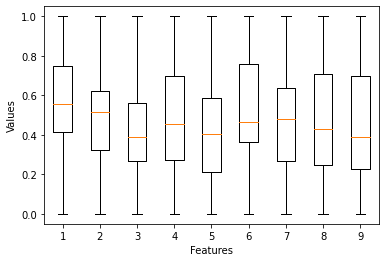

In [ ]:
import matplotlib.pyplot as plt

x_train_scaled, min_scale_by, max_scale_by = min_max_scale(x_train)
x_test_scaled = min_max_scale(x_test, min_scale_by, max_scale_by)

plt.boxplot(x_train_scaled)
plt.xlabel('Features')
plt.ylabel('Values')

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
def knn_kfolds(X, y, n_folds, n_neighbors, random_state=None):
    
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = random_state)
    
    r_squared_sum = 0
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        model = KNeighborsRegressor(n_neighbors)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        r_squared = r2_score(y_test, y_hat)
        r_squared_sum += r_squared
        
    avg_score = r_squared_sum / n_folds
    return avg_score

0.6126298734071061


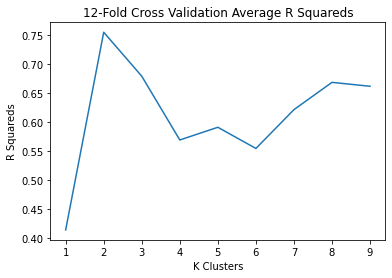

In [ ]:
%matplotlib inline
allk = np.arange(1, 10)
r_squareds = []

for k in allk:
    r_squareds.append(knn_kfolds(x_train, y_train, 4, k, random_state = 3))
    

plt.plot(allk, r_squareds)
plt.xticks(allk)
plt.xlabel('K Clusters')
plt.ylabel('R Squareds')
plt.title("12-Fold Cross Validation Average R Squareds")

rsqmean = np.mean(r_squareds)
print(rsqmean)

0.5607022168441682


Text(0.5, 1.0, 'Actual vs. Predicted Win Rate')

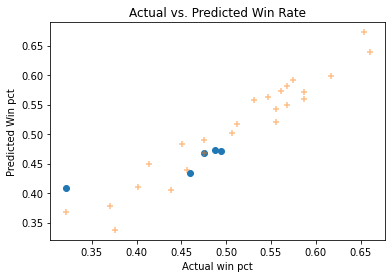

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

RSquaredlinreg = r2_score(y_test,y_pred)

print(RSquaredlinreg)
plt.scatter(y_test, y_pred, marker = 'o')
plt.scatter(y_train, model.predict(x_train), marker = '+', alpha = 0.5)
plt.xlabel("Actual win pct")
plt.ylabel("Predicted Win pct")
plt.title("Actual vs. Predicted Win Rate")


In [ ]:
batting2022 = pd.read_csv("mlb batting - 2022.csv")
pitching2022 = pd.read_csv("mlb pitching - 2022.csv")
batting2022 = batting2022[["Team", "ISO", "BABIP", "AVG", "wRC+", "WAR"]]
pitching2022 = pitching2022[["Team", "W", "L", "ERA", "WAR", "K/9", "xFIP"]]
pitching2022["PCT"] = pitching2022["W"] / ( pitching2022 ["L"] + pitching2022 ["W"])
pitching2022 = pitching2022.drop(["W", "L"], axis = 1)

In [ ]:
all_data_2022 = pd.merge(left=batting2022, right=pitching2022, left_on='Team', right_on='Team')
teams = np.array(all_data["Team"])
x = np.array(all_data.drop(["PCT", "Team"],  axis=1))
forecast = model.predict(x)
print(forecast)
print(teams)


[0.57153162 0.59770245 0.63889403 0.672539   0.57242988 0.54294024
 0.59140925 0.56263665 0.55695349 0.54973119 0.49048491 0.47350471
 0.48257381 0.40953356 0.5021067  0.55978001 0.51692019 0.5817103
 0.47054395 0.40527767 0.43912977 0.44872592 0.37760391 0.46739741
 0.51972828 0.43331647 0.36716079 0.46769797 0.33743166 0.40810491]
['HOU' 'TBR' 'SFG' 'LAD' 'TOR' 'STL' 'CHW' 'ATL' 'OAK' 'BOS' 'NYM' 'SDP'
 'MIN' 'WSN' 'PHI' 'MIL' 'CIN' 'NYY' 'CLE' 'CHC' 'KCR' 'MIA' 'TEX' 'LAA'
 'SEA' 'COL' 'ARI' 'DET' 'PIT' 'BAL']


In [ ]:
team_forecast = {}
for i in range(len(teams)):
  team_forecast[teams[i]] = forecast[i]
print(team_forecast)

{'HOU': 0.5715316197578397, 'TBR': 0.5977024452408284, 'SFG': 0.6388940308099355, 'LAD': 0.6725389967472755, 'TOR': 0.5724298809302231, 'STL': 0.542940236832395, 'CHW': 0.5914092523043768, 'ATL': 0.5626366495434468, 'OAK': 0.5569534857026198, 'BOS': 0.5497311853880696, 'NYM': 0.49048491401198047, 'SDP': 0.47350471292207574, 'MIN': 0.4825738115377296, 'WSN': 0.4095335576522063, 'PHI': 0.5021067015150849, 'MIL': 0.5597800061273638, 'CIN': 0.5169201884296365, 'NYY': 0.5817103008356493, 'CLE': 0.47054394824180834, 'CHC': 0.4052776693465979, 'KCR': 0.4391297683754763, 'MIA': 0.4487259170626682, 'TEX': 0.3776039079558895, 'LAA': 0.46739740933877394, 'SEA': 0.5197282818880076, 'COL': 0.43331646747000807, 'ARI': 0.3671607874208737, 'DET': 0.46769797424324594, 'PIT': 0.33743166398830565, 'BAL': 0.40810490970331814}


In [ ]:
def probability(a,  b):
  return a + b - (2 * a * b)

In [ ]:
print (probability(team_forecast['SFG'], team_forecast['PIT']))

0.5451595429414564
